# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']
test_images\solidWhiteCurve.jpg  image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images\solidWhiteRight.jpg  image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images\solidYellowCurve.jpg  image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images\solidYellowCurve2.jpg  image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images\solidYellowLeft.jpg  image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images\whiteCarLaneSwitch.jpg  image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


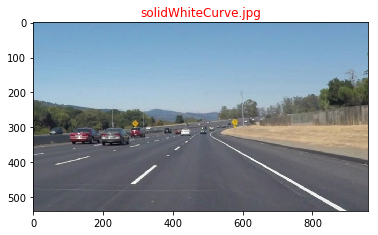

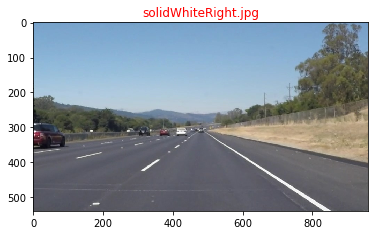

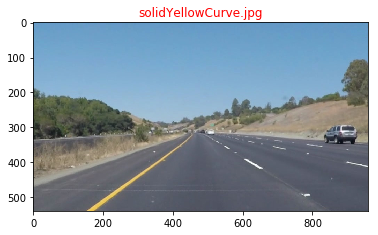

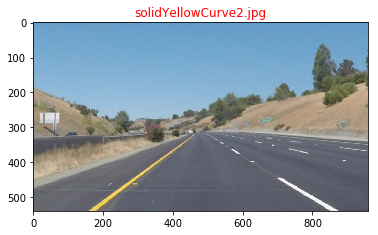

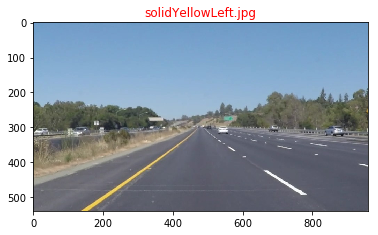

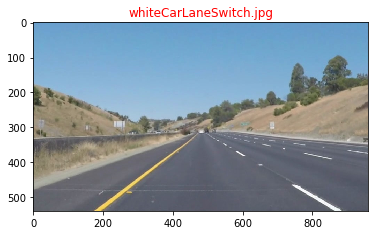

In [2]:
#reading in an image
import os, sys
file_dir = "test_images"
file_list = os.listdir(file_dir)
print(file_list)

file_path_lists = []

for file in file_list:
    image = mpimg.imread(os.path.join(file_dir,  file))
    file_path_lists.append(os.path.join(file_dir,  file))
    fig = plt.figure()
    img = plt.imshow(image)
    title = plt.title(file)
    plt.setp(title, color='r') 
    print(os.path.join(file_dir,  file),' image is:', type(image), 'with dimensions:', image.shape)
plt.show()


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def hlsscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(vertices, img, lines, color=[255, 0, 0], thickness=12):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    left_lines = []  #np.array([[]]) #[]
    right_lines = [] #np.array([[]]) #[] 
    #print lines
    #for line in lines:
        #for x1,y1,x2,y2 in line:
            #print('x1:', x1, 'y1:', y1, '---> x2:', x2, 'y2:', y2 )

    if lines != []:
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                b = y1 - slope * x1
                if slope > 0:
                    right_lines.append([x1, y1, x2, y2, slope, b])
                else:
                    left_lines.append([x1, y1, x2, y2, slope, b])

        left_Lines_array = np.mean(left_lines, axis=0, dtype=np.float64)
        right_Lines_array = np.mean(right_lines, axis=0, dtype=np.float64)
        #print('left_lines:', left_lines)
        #print('right_lines:', right_lines)
        #print('left_Lines_array:', left_Lines_array)
        #print('right_Lines_array:', right_Lines_array)
        #print('left_Lines_array[1]:', left_Lines_array[1])
        #print('left_Lines_array[5]:', left_Lines_array[[5]])

        # top y,x of left lines
        left_y1 = vertices[0][1][1] 
        # top x, x = (y - b)/k
        left_x1 = int((left_y1 - left_Lines_array[5]) / left_Lines_array[4])

        # bottom y,x of left lines
        left_y0 = vertices[0][0][1]    #540
        left_x0 = int((left_y0 - left_Lines_array[5])/left_Lines_array[4])

        #draw left lines
        cv2.line(img, (left_x0, left_y0), (left_x1, left_y1), color, thickness)

        # top y,x of rights lines
        right_y1 = vertices[0][1][1] #325
        right_x1 = int((right_y1 - right_Lines_array[5])/right_Lines_array[4])

        # bottom y,x of right lines
        right_y0 = vertices[0][0][1] #540
        right_x0 = int((right_y0 - right_Lines_array[5])/right_Lines_array[4])

        #draw right lines
        cv2.line(img, (right_x0, right_y0), (right_x1, right_y1), color, thickness)

    return img


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, vertices):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = np.copy(img)
    return draw_lines(vertices, line_img, lines)

def hough_lines_vector(img, rho, theta, threshold, min_line_len, max_line_gap, vertices):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [4]:
kernel_size = 5
low_threshold = 50
high_threshold = 160
    
rho = 2
theta = np.pi/180
threshold = 50
min_line_len = 100
max_line_gap = 160

image = cv2.imread(file_path_lists[0])
vertices = np.array([[(0,image.shape[0]),(418, 325), (550, 325), (image.shape[1], image.shape[0])]], dtype=np.int32)


In [5]:
def handle_img(img, debug=False):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    gaus_blur_image = gaussian_blur(image, kernel_size=kernel_size)
    if debug==True:
        plt.imshow(gaus_blur_image)
        plt.title("gaussian blur image")
        plt.show()
        
    canny_image = canny(gaus_blur_image, low_threshold, high_threshold)
    if debug==True:
        plt.imshow(canny_image)
        plt.title("canny image")
        plt.show()
        
    reg_image = region_of_interest(canny_image, vertices)
    if debug==True:
        plt.imshow(reg_image)
        plt.title("region of interest image")
        plt.show()
        
    hough_image = hough_lines(reg_image, rho, theta, threshold, min_line_len, max_line_gap, vertices)
    if debug==True:
        plt.imshow(hough_image)
        plt.title("hough line image")
        plt.show()
    
    return hough_image

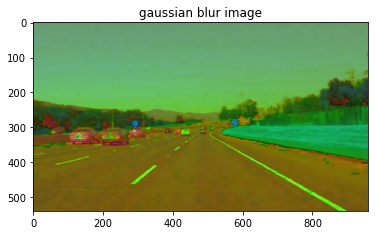

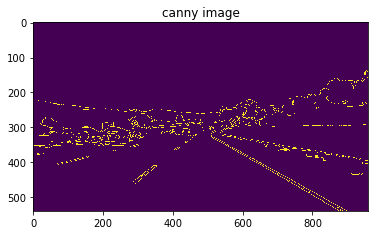

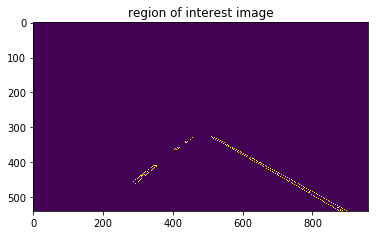

d:\ProgramData\Anaconda3\envs\lenet-env\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


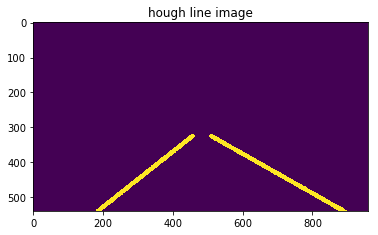

In [6]:
image = cv2.imread(file_path_lists[0])
final_img = handle_img(image, True)


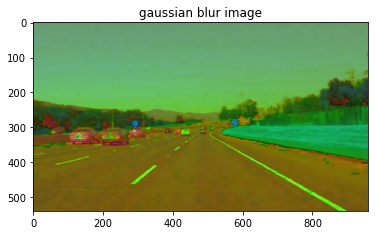

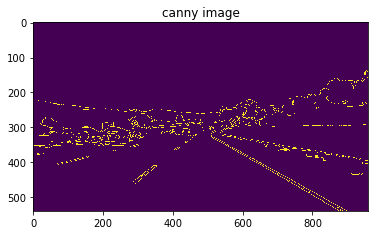

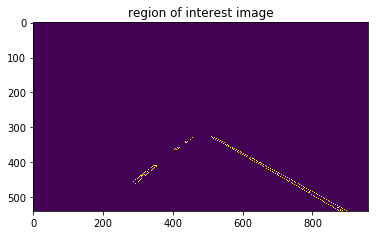

d:\ProgramData\Anaconda3\envs\lenet-env\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


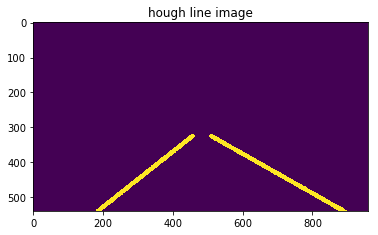

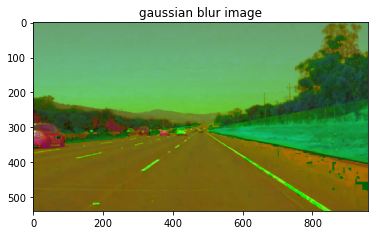

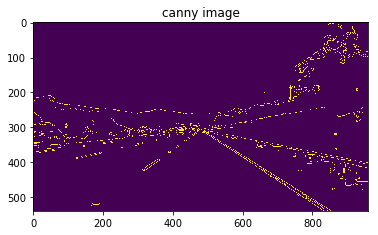

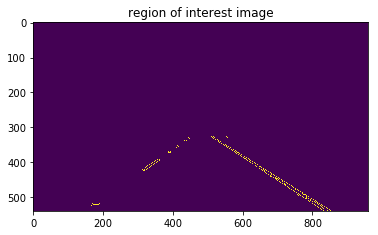

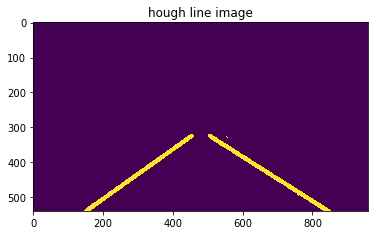

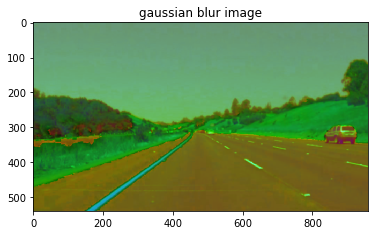

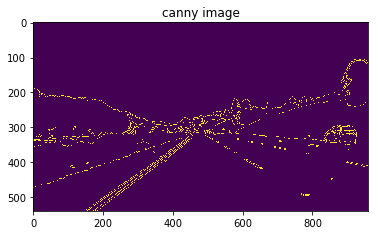

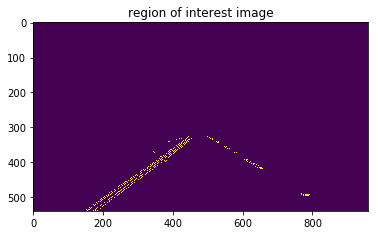

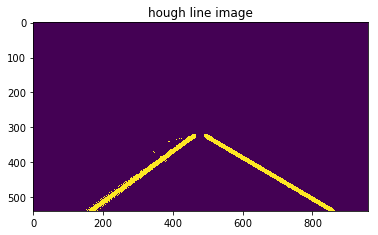

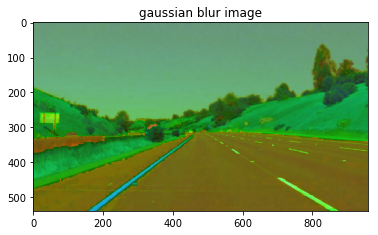

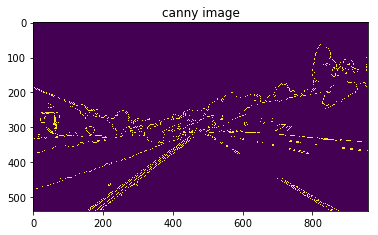

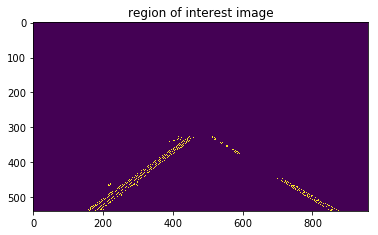

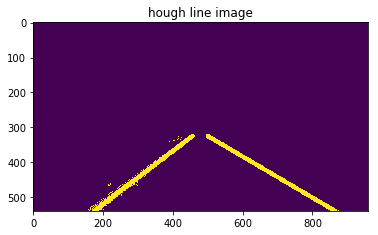

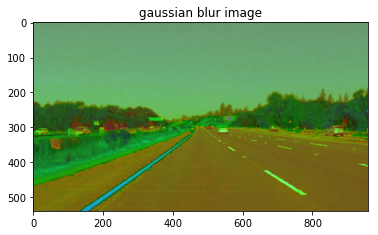

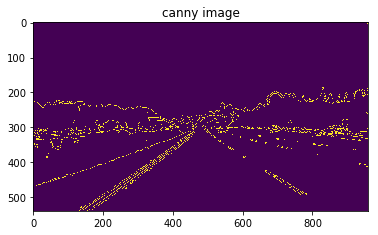

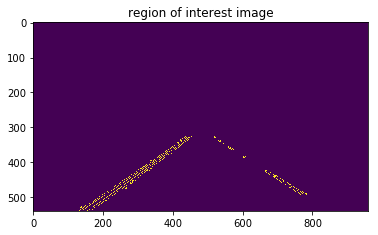

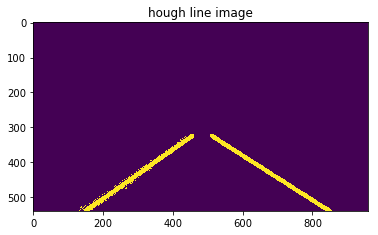

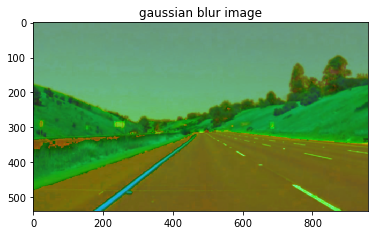

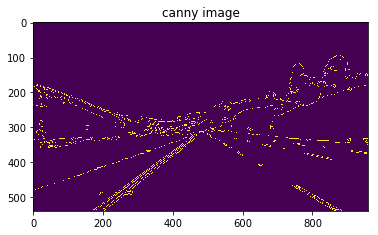

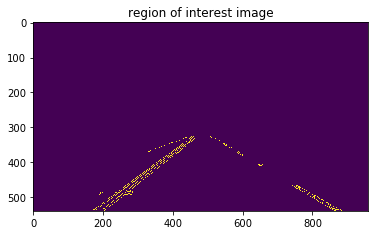

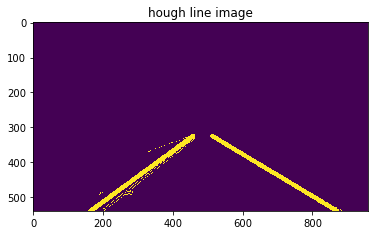

In [7]:
for img in file_list:
    image = cv2.imread(os.path.join(file_dir, img))
    final_img = handle_img(image, True)

In [16]:
def handle_img_scatter(img, debug=False, printinfo=False):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    gaus_blur_image = gaussian_blur(image, kernel_size=kernel_size)
        
    canny_image = canny(gaus_blur_image, low_threshold, high_threshold)
        
    reg_image = region_of_interest(canny_image, vertices)
        
    lines = hough_lines_vector(reg_image, rho, theta, threshold, min_line_len, max_line_gap, vertices)
    if printinfo==True:   
        print(lines)
    
    left_lines = []  
    right_lines = [] 
    
    left_lines_x = []
    left_lines_y = []
    right_lines_x = []
    right_lines_y = []
    
    if debug==True:
        if lines != []:
            for line in lines:
                for x1,y1,x2,y2 in line:
                    slope = (y2-y1)/(x2-x1)
                    if (slope > 0 ):
                        right_lines.append([x1, y1, x2, y2])

                    if (slope < 0):
                        left_lines.append([x1, y1, x2, y2])
                        
            if printinfo==True:    
                print('left_lines: ',left_lines)
                print('right_lines: ',right_lines)
            
            plt.title("hough Line point plot")
            plt.xlim(0, image.shape[1])
            plt.ylim(image.shape[0], 0)
            #plt.legend(loc='upper left')   
            for x1,y1,x2,y2 in left_lines:
                #plt.plot(x1, y1, 'ro', lw=2)
                #plt.plot(x2, y2, 'ro', lw=2)
                plt.scatter(x1, y1, c='r', marker='o')
                plt.scatter(x2, y2, c='r', marker='o')
                left_lines_x.append(x1)
                left_lines_x.append(x2)
                left_lines_y.append(y1)
                left_lines_y.append(y2)

            for xx1,yy1,xx2,yy2 in right_lines:
                plt.plot(xx1, yy1, 'bo', lw=2)
                plt.plot(xx2, yy2, 'bo', lw=2)
                right_lines_x.append(xx1)
                right_lines_x.append(xx2)
                right_lines_y.append(yy1)
                right_lines_y.append(yy2)
                
            leftline_c = np.polyfit(left_lines_x, left_lines_y, 1)
            leftline_func = np.poly1d(leftline_c)
            plt.plot(left_lines_x, leftline_func(left_lines_x), 'gv--', lw=1)

            rightline_c = np.polyfit(right_lines_x, right_lines_y, 1)
            rightline_func = np.poly1d(rightline_c)
            plt.plot(right_lines_x, rightline_func(right_lines_x), 'rv--', lw=1)
            
            plt.show()
    
    return 

[[[508 325 829 510]]

 [[513 325 848 510]]

 [[290 463 437 340]]

 [[298 457 461 325]]

 [[281 460 458 326]]

 [[292 462 450 335]]

 [[518 328 798 489]]

 [[280 462 418 355]]

 [[308 438 463 325]]

 [[579 367 836 510]]]
left_lines:  [[290, 463, 437, 340], [298, 457, 461, 325], [281, 460, 458, 326], [292, 462, 450, 335], [280, 462, 418, 355], [308, 438, 463, 325]]
right_lines:  [[508, 325, 829, 510], [513, 325, 848, 510], [518, 328, 798, 489], [579, 367, 836, 510]]


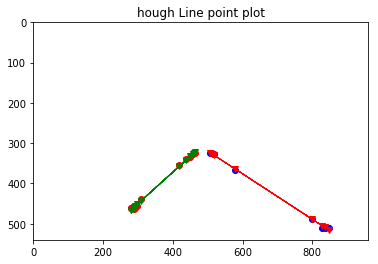

[[[512 325 808 510]]

 [[509 327 790 510]]

 [[506 325 789 508]]

 [[310 423 454 326]]

 [[319 425 457 325]]

 [[508 325 794 504]]

 [[314 425 452 325]]]
left_lines:  [[310, 423, 454, 326], [319, 425, 457, 325], [314, 425, 452, 325]]
right_lines:  [[512, 325, 808, 510], [509, 327, 790, 510], [506, 325, 789, 508], [508, 325, 794, 504]]


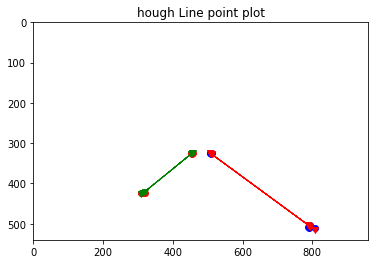

[[[195 510 457 326]]

 [[217 505 454 332]]

 [[189 510 416 351]]

 [[221 510 445 341]]

 [[232 503 428 356]]

 [[495 325 782 497]]

 [[514 332 786 495]]

 [[206 496 442 330]]

 [[208 500 457 325]]

 [[257 475 455 331]]

 [[497 325 780 495]]

 [[279 448 436 338]]

 [[214 509 439 333]]]
left_lines:  [[195, 510, 457, 326], [217, 505, 454, 332], [189, 510, 416, 351], [221, 510, 445, 341], [232, 503, 428, 356], [206, 496, 442, 330], [208, 500, 457, 325], [257, 475, 455, 331], [279, 448, 436, 338], [214, 509, 439, 333]]
right_lines:  [[495, 325, 782, 497], [514, 332, 786, 495], [497, 325, 780, 495]]


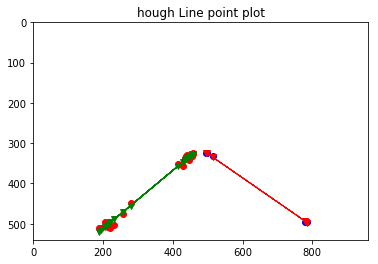

[[[216 509 452 331]]

 [[201 510 452 328]]

 [[226 510 461 326]]

 [[209 497 415 352]]

 [[503 325 822 509]]

 [[521 333 804 510]]

 [[221 495 397 363]]

 [[250 474 448 325]]

 [[511 325 791 499]]

 [[253 495 456 331]]

 [[510 328 781 497]]

 [[277 387 396 339]]

 [[241 500 460 328]]

 [[194 509 372 380]]

 [[630 396 813 510]]

 [[228 507 451 332]]

 [[267 393 436 325]]]
left_lines:  [[216, 509, 452, 331], [201, 510, 452, 328], [226, 510, 461, 326], [209, 497, 415, 352], [221, 495, 397, 363], [250, 474, 448, 325], [253, 495, 456, 331], [277, 387, 396, 339], [241, 500, 460, 328], [194, 509, 372, 380], [228, 507, 451, 332], [267, 393, 436, 325]]
right_lines:  [[503, 325, 822, 509], [521, 333, 804, 510], [511, 325, 791, 499], [510, 328, 781, 497], [630, 396, 813, 510]]


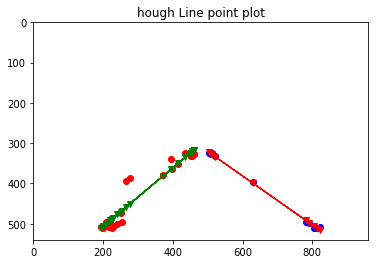

[[[181 510 455 325]]

 [[198 509 444 336]]

 [[185 501 446 325]]

 [[206 510 441 339]]

 [[518 330 769 493]]

 [[513 326 781 493]]

 [[326 417 455 326]]

 [[208 510 415 360]]

 [[518 327 784 493]]

 [[221 480 436 329]]

 [[193 503 443 328]]

 [[291 428 442 337]]

 [[533 341 777 493]]

 [[178 507 452 329]]

 [[266 476 440 325]]

 [[558 358 767 493]]

 [[265 475 431 331]]]
left_lines:  [[181, 510, 455, 325], [198, 509, 444, 336], [185, 501, 446, 325], [206, 510, 441, 339], [326, 417, 455, 326], [208, 510, 415, 360], [221, 480, 436, 329], [193, 503, 443, 328], [291, 428, 442, 337], [178, 507, 452, 329], [266, 476, 440, 325], [265, 475, 431, 331]]
right_lines:  [[518, 330, 769, 493], [513, 326, 781, 493], [518, 327, 784, 493], [533, 341, 777, 493], [558, 358, 767, 493]]


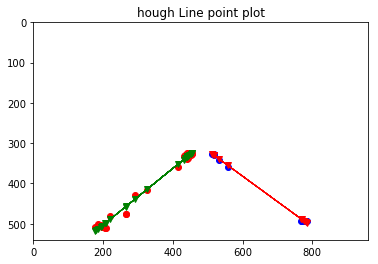

[[[216 510 462 325]]

 [[230 510 421 361]]

 [[266 487 457 338]]

 [[504 325 825 510]]

 [[213 505 450 332]]

 [[241 510 421 369]]

 [[509 325 824 506]]

 [[292 381 455 325]]

 [[235 488 453 329]]

 [[266 492 436 350]]

 [[265 482 455 333]]

 [[267 492 455 340]]

 [[581 371 833 510]]

 [[234 490 467 326]]

 [[513 329 819 506]]

 [[591 371 804 504]]

 [[242 508 468 325]]

 [[304 376 449 326]]

 [[271 390 467 327]]]
left_lines:  [[216, 510, 462, 325], [230, 510, 421, 361], [266, 487, 457, 338], [213, 505, 450, 332], [241, 510, 421, 369], [292, 381, 455, 325], [235, 488, 453, 329], [266, 492, 436, 350], [265, 482, 455, 333], [267, 492, 455, 340], [234, 490, 467, 326], [242, 508, 468, 325], [304, 376, 449, 326], [271, 390, 467, 327]]
right_lines:  [[504, 325, 825, 510], [509, 325, 824, 506], [581, 371, 833, 510], [513, 329, 819, 506], [591, 371, 804, 504]]


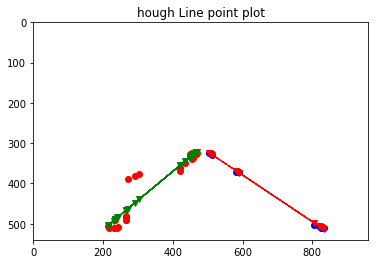

In [17]:
for img in file_list:
    image = cv2.imread(os.path.join(file_dir, img))
    final_img = handle_img_scatter(image, True, True)

In [10]:
# at height=540, there are many noise point, so change the vertices point to reduce noise
vertices = np.array([[(0,image.shape[0]-30),(418, 325), (550, 325), (image.shape[1], image.shape[0]-30)]], dtype=np.int32)

d:\ProgramData\Anaconda3\envs\lenet-env\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


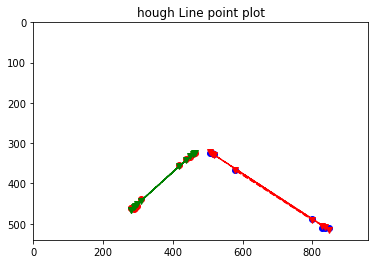

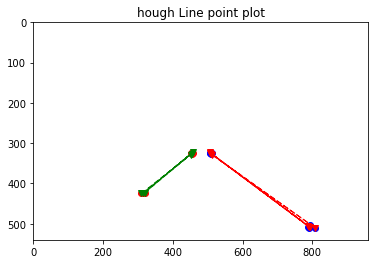

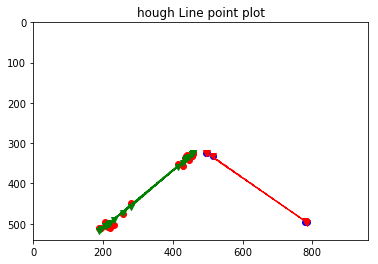

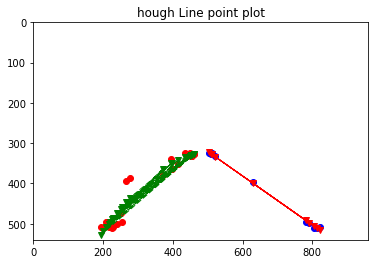

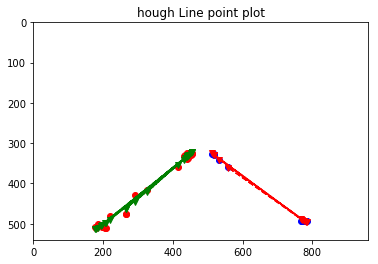

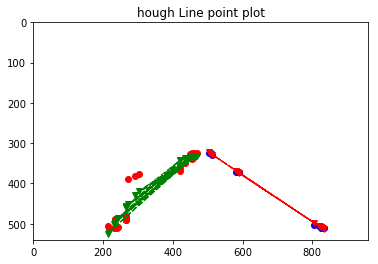

In [11]:
for img in file_list:
    image = cv2.imread(os.path.join(file_dir, img))
    final_img = handle_img_scatter(image, True, False)

In [12]:
# 6. Draw the lines on the image
#line_edges = weighted_img(hough_img, image, α=0.8, β=1.0, λ=0.0)
#plt.imshow(line_edges)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def handle_images(img):
    image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    ##### constant
    kernel_size = 5
    low_threshold = 50
    high_threshold = 160

    rho = 2
    theta = np.pi/180
    threshold = 50
    min_line_len = 100
    max_line_gap = 160
    vertices = np.array([[(0,image.shape[0]),(418, 325), (550, 325), (image.shape[1], image.shape[0])]], dtype=np.int32)
    #####
    
    gaus_blur_image = gaussian_blur(image, kernel_size=kernel_size)
        
    canny_image = canny(gaus_blur_image, low_threshold, high_threshold)
        
    reg_image = region_of_interest(canny_image, vertices)
    
    lines = hough_lines_vector(reg_image, rho, theta, threshold, min_line_len, max_line_gap, vertices)

    left_lines_x = []
    left_lines_y = []
    right_lines_x = []
    right_lines_y = []
    
    if lines != []:
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                if (slope > 0.5 and slope < 5.6 ):
                    right_lines_x.append(x1)
                    right_lines_x.append(x2)
                    right_lines_y.append(y1)
                    right_lines_y.append(y2)

                if (slope < -0.5 and slope > -5.6):
                    left_lines_x.append(x1)
                    left_lines_x.append(x2)
                    left_lines_y.append(y1)
                    left_lines_y.append(y2)
                    
        if left_lines_x != [] and right_lines_x != []:
            leftline_c = np.polyfit(left_lines_x, left_lines_y, 1)
            rightline_c = np.polyfit(right_lines_x, right_lines_y, 1)

            hough_img = np.copy(img)
            color = [255, 0, 0]
            thickness = 12

            #draw left lines
            ly1 = image.shape[0]
            lx1 = int((ly1 - leftline_c[1])/leftline_c[0])
            ly2 = 325
            lx2 = int((ly2 - leftline_c[1])/leftline_c[0])
            cv2.line(hough_img, (lx1,ly1), (lx2,ly2), color, thickness)

            #draw right lines
            ry1 = image.shape[0]
            rx1 = int((ry1 - rightline_c[1])/rightline_c[0])
            ry2 = 325
            rx2 = int((ry2 - rightline_c[1])/rightline_c[0])        
            cv2.line(hough_img, (rx1,ry1), (rx2,ry2), [0, 0, 255], thickness)

            final_img = weighted_img(hough_img, img, α=0.8, β=1.0, λ=0.0)
        
            return final_img
        else:
            return img

In [15]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    return handle_images(image)

Let's try the one with the solid white lane on the right first ...

In [18]:
white_output = 'white_f3.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white_f3.mp4
[MoviePy] Writing video white_f3.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:08<00:00, 26.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white_f3.mp4 

Wall time: 9.37 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [20]:
yellow_output = 'yellow_f3.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow_f3.mp4
[MoviePy] Writing video yellow_f3.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:29<00:00, 24.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow_f3.mp4 

Wall time: 30.5 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
def handle_images_extra(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ##### constant
    kernel_size = 5
    low_threshold = 50
    high_threshold = 160

    rho = 2
    theta = np.pi/180
    threshold = 50
    min_line_len = 100
    max_line_gap = 160
    vertices = np.array([[(0,image.shape[0]),(418, 425), (550, 425), (image.shape[1], image.shape[0])]], dtype=np.int32)
    #####
    
    gaus_blur_image = gaussian_blur(image, kernel_size=kernel_size)
        
    canny_image = canny(gaus_blur_image, low_threshold, high_threshold)
        
    reg_image = region_of_interest(canny_image, vertices)
    
    lines = hough_lines_vector(reg_image, rho, theta, threshold, min_line_len, max_line_gap, vertices)

    left_lines_x = []
    left_lines_y = []
    right_lines_x = []
    right_lines_y = []
    
    if lines != []:
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                if (slope > 0.4 and slope < 50 ):
                    right_lines_x.append(x1)
                    right_lines_x.append(x2)
                    right_lines_y.append(y1)
                    right_lines_y.append(y2)

                if (slope < -0.4 and slope > -50):
                    left_lines_x.append(x1)
                    left_lines_x.append(x2)
                    left_lines_y.append(y1)
                    left_lines_y.append(y2)
                    
        if left_lines_x != [] and right_lines_x != []:
            leftline_c = np.polyfit(left_lines_x, left_lines_y, 2)
            leftline_func = np.poly1d(leftline_c)
            rightline_c = np.polyfit(right_lines_x, right_lines_y, 2)
            rightline_func = np.poly1d(rightline_c)

            hough_img = np.copy(img)
            color = [255, 0, 0]
            thickness = 12

            #draw left lines
            lx1 = left_lines_x[0] #int((ly1 - leftline_c[1])/leftline_c[0])
            ly1 = int(leftline_func(lx1))
            lx2 = left_lines_x[-1]
            ly2 = int(leftline_func(lx2))
            cv2.line(hough_img, (lx1,ly1), (lx2,ly2), color, thickness)

            #draw right lines
            rx1 = right_lines_x[0]  #int((ry1 - rightline_c[1])/rightline_c[0])
            ry1 = int(rightline_func(rx1))
            rx2 = right_lines_x[-1]  #int((ry2 - rightline_c[1])/rightline_c[0])   
            ry2 = int(rightline_func(rx2))
                 
            cv2.line(hough_img, (rx1,ry1), (rx2,ry2), [0, 0, 255], thickness)

            final_img = weighted_img(hough_img, img, α=0.8, β=1.0, λ=0.0)
        
            return final_img
        else:
            return img

In [ ]:
def process_image_extra(image):
  
    return handle_images_extra(image)

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image_extra)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))